## Opening up multiple ROOT files with extracted calorimeter features. These are mixed electrons and gammas at different energies.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
dataDir = "/data/LCD/V2/MLDataset/"
dataFileNames = []
for i in range(20):
    dataFileNames.append("GammaEscan/GammaEscan_" + str(i) + ".h5")
    dataFileNames.append("Pi0Escan/Pi0Escan_" + str(i) + ".h5")

In [3]:
dataFiles = []
for i in range(len(dataFileNames)):
    dataFiles.append(h5py.File(dataDir + dataFileNames[i], "r"))

In [4]:
print dataFiles[0].keys()

[u'ECAL', u'ECAL_E', u'ECAL_nHits', u'ECAL_ratioFirstLayerToSecondLayerE', u'ECAL_ratioFirstLayerToTotalE', u'ECALmomentX0', u'ECALmomentX1', u'ECALmomentX2', u'ECALmomentX3', u'ECALmomentX4', u'ECALmomentX5', u'ECALmomentY0', u'ECALmomentY1', u'ECALmomentY2', u'ECALmomentY3', u'ECALmomentY4', u'ECALmomentY5', u'ECALmomentZ0', u'ECALmomentZ1', u'ECALmomentZ2', u'ECALmomentZ3', u'ECALmomentZ4', u'ECALmomentZ5', u'HCAL', u'HCAL_E', u'HCAL_ECAL_ERatio', u'HCAL_ECAL_nHitsRatio', u'HCAL_nHits', u'HCAL_ratioFirstLayerToSecondLayerE', u'HCAL_ratioFirstLayerToTotalE', u'HCALmomentX0', u'HCALmomentX1', u'HCALmomentX2', u'HCALmomentX3', u'HCALmomentX4', u'HCALmomentX5', u'HCALmomentY0', u'HCALmomentY1', u'HCALmomentY2', u'HCALmomentY3', u'HCALmomentY4', u'HCALmomentY5', u'HCALmomentZ0', u'HCALmomentZ1', u'HCALmomentZ2', u'HCALmomentZ3', u'HCALmomentZ4', u'HCALmomentZ5', u'conversion', u'energy', u'pdgID']


## Combining samples, and explicitly labelling the electrons as class '1' and photons as class '0'.

In [5]:
data = []
features = dataFiles[0].keys()

badKeys = ['ECAL', 'HCAL', 'ECAL_ratioFirstLayerToSecondLayerE', 'HCAL_ratioFirstLayerToSecondLayerE',
           'conversion', 'energy', 'ECALmomentX0', 'ECALmomentY0', 'ECALmomentZ0', 'HCALmomentX0', 'HCALmomentY0',
           'HCALmomentZ0',
          'HCALmomentX1', 'HCALmomentX2', 'HCALmomentX3', 'HCALmomentX4', 'HCALmomentX5',
          'HCALmomentY1', 'HCALmomentY2', 'HCALmomentY3', 'HCALmomentY4', 'HCALmomentY5',
          'HCALmomentZ1', 'HCALmomentZ2', 'HCALmomentZ3', 'HCALmomentZ4', 'HCALmomentZ5']
for key in badKeys:
    features.remove(key)

import sys
for count, feature in enumerate(features):
    
    print "Working on feature", feature
    sys.stdout.flush()
    
    newFeature = []
    for fileN in range(len(dataFiles)):
        newFeature += dataFiles[fileN][feature]
        
    if feature == 'pdgID':
        y = np.array([int(abs(x) == 111) for x in newFeature]);
    else:
        data.append(newFeature);
        
features.remove('pdgID')

X = np.column_stack(data)

y = y[np.isfinite(X).all(axis=1)]
X = X[np.isfinite(X).all(axis=1)]

Working on feature ECAL_E
Working on feature ECAL_nHits
Working on feature ECAL_ratioFirstLayerToTotalE
Working on feature ECALmomentX1
Working on feature ECALmomentX2
Working on feature ECALmomentX3
Working on feature ECALmomentX4
Working on feature ECALmomentX5
Working on feature ECALmomentY1
Working on feature ECALmomentY2
Working on feature ECALmomentY3
Working on feature ECALmomentY4
Working on feature ECALmomentY5
Working on feature ECALmomentZ1
Working on feature ECALmomentZ2
Working on feature ECALmomentZ3
Working on feature ECALmomentZ4
Working on feature ECALmomentZ5
Working on feature HCAL_E
Working on feature HCAL_ECAL_ERatio
Working on feature HCAL_ECAL_nHitsRatio
Working on feature HCAL_nHits
Working on feature HCAL_ratioFirstLayerToTotalE
Working on feature pdgID


In [6]:
from sklearn.cross_validation import train_test_split

X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=492)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [8]:
y_predicted = bdt.predict(X_test)
#target_names = ['class 0', 'class 1', 'class 2']
target_names = ['photon', 'electron']
print (classification_report(y_test, y_predicted, target_names=target_names))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

             precision    recall  f1-score   support

     photon       0.75      0.78      0.76     44400
   electron       0.77      0.74      0.75     44040

avg / total       0.76      0.76      0.76     88440

Area under ROC curve: 0.8311


Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).  
P = \frac{T_p}{T_p+F_p}  
Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).  
R = \frac{T_p}{T_p + F_n}

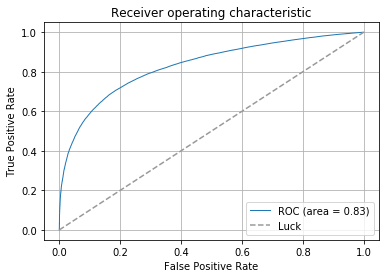

In [9]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

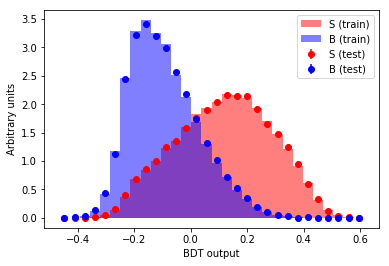

In [10]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='S (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='B (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)

Feature ranking:
1. ECAL_nHits (0.262327)
2. ECALmomentY5 (0.136302)
3. ECAL_E (0.121541)
4. ECALmomentZ1 (0.087116)
5. ECALmomentY1 (0.063538)
6. ECALmomentX5 (0.058756)
7. HCAL_nHits (0.042656)
8. ECALmomentY4 (0.041717)
9. ECALmomentY2 (0.026004)
10. ECAL_ratioFirstLayerToTotalE (0.024097)
11. ECALmomentY3 (0.023396)
12. ECALmomentZ2 (0.021951)
13. ECALmomentX4 (0.021255)
14. ECALmomentX1 (0.016328)
15. ECALmomentX2 (0.013683)
16. HCAL_ratioFirstLayerToTotalE (0.012366)
17. HCAL_E (0.011821)
18. ECALmomentX3 (0.008615)
19. HCAL_ECAL_ERatio (0.006148)
20. ECALmomentZ3 (0.000224)
21. HCAL_ECAL_nHitsRatio (0.000159)
22. ECALmomentZ4 (0.000000)
23. ECALmomentZ5 (0.000000)


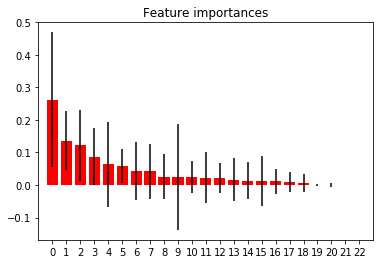

In [23]:
importances = bdt.feature_importances_
std = np.std([tree.feature_importances_ for tree in bdt.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]))
plt.xlim([-1, X.shape[1]])
plt.show()